# 3-peaks pattern recognizer

In [190]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np

In [185]:
df = dl.get_minutely_data("HNTUSDT", past=False)
df["timestamp"] = list(map(lambda x: datetime.utcfromtimestamp(x / 1e3), df.timestamp))
df.set_index("timestamp", inplace=True)

In [19]:
a = df.to_numpy()

In [28]:
ma = df.open.rolling(window=10000).mean().diff()

In [107]:
def find_pivots(df, unit = 1000):
    """returns timestamps of peaks"""
    i = 0
    price = df.open.to_list()
    timestamps = df.timestamp.to_list()
    h_ts = [] #high timestamps
    l_ts = []
    past = price[0]
    now = price[0]
    future = price[unit]
    while True:
        if now>past and now>future:
            h_ts.append(timestamps[i])
        elif now<past and now<future:
            l_ts.append(timestamps[i])
        i += unit
        past = now
        now = future
        try:
            future = price[i+unit]
        except:
            break
    return h_ts, l_ts
                

In [112]:
h, l = find_pivots(df)

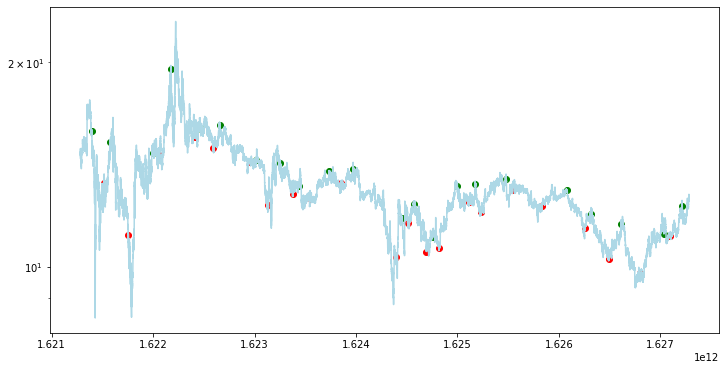

In [113]:

fig, ax = plt.subplots(figsize=(12, 6))
plotdf = df[-200000:-100000]
h = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, h))
l = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, l))

plt.yscale("log")
ax.plot(plotdf.set_index("timestamp").open, c="lightblue")
ax.scatter(h, plotdf.set_index("timestamp").reindex(h)["open"], c="green")
ax.scatter(l, plotdf.set_index("timestamp").reindex(l)["open"], c="red")

In [114]:
def get_daily_vol(close, span0=10000):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=2))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

In [186]:
vol = get_daily_vol(df.open)

In [187]:
vol

timestamp
2020-09-26 09:01:00         NaN
2020-09-26 09:02:00    0.502381
2020-09-26 09:03:00    0.383427
2020-09-26 09:04:00    0.322004
2020-09-26 09:05:00    0.279546
                         ...   
2021-10-04 03:26:00    0.071474
2021-10-04 03:27:00    0.071471
2021-10-04 03:28:00    0.071468
2021-10-04 03:29:00    0.071465
2021-10-04 03:30:00    0.071462
Name: open, Length: 535446, dtype: float64

In [188]:
def get_t_events(g_raw, h, m):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold pandas series vol
    m -- minimum threshold (float, ex: 0.02)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    h = h.map(lambda x: x if x>=m else m)
    t_events, s_pos, s_neg = [], 0, 0
#     side = []
    diff = np.log(g_raw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            print(s_pos+diff.loc[i], type(s_pos+diff.loc[i]))
            print(s_neg+diff.loc[i], type(s_neg+diff.loc[i]))
            break
        s_pos, s_neg=max(0., pos), min(0., neg)
        try: 
            th = h.loc[i]
        except:
            try:
                th = h[h.index.get_loc(i, method="pad")]
            except: #i is before the first ever h
                continue
        if s_neg<-th:
            s_neg=0
            t_events.append(i)
#             side.append(0)
        if s_pos>th:
            s_pos=0
            t_events.append(i)
#             side.append(1)
    return pd.DatetimeIndex(t_events)

In [191]:
t_events = get_t_events(df.close,h=vol, m=0.01)
t_events

DatetimeIndex(['2020-09-26 09:01:00', '2020-09-26 09:01:00',
               '2020-09-26 12:39:00', '2020-09-26 13:31:00',
               '2020-09-27 06:53:00', '2020-09-27 19:23:00',
               '2020-09-28 04:12:00', '2020-09-28 06:16:00',
               '2020-09-28 07:04:00', '2020-09-28 08:24:00',
               ...
               '2021-09-29 17:45:00', '2021-09-30 01:12:00',
               '2021-09-30 11:41:00', '2021-10-01 08:02:00',
               '2021-10-01 11:46:00', '2021-10-02 06:34:00',
               '2021-10-03 15:22:00', '2021-10-03 15:47:00',
               '2021-10-03 19:06:00', '2021-10-04 03:04:00'],
              dtype='datetime64[ns]', length=778, freq=None)

## TODO: Continue from 1.0-get-vol and convert all that to here